In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import copy
import cmath as cm
from matplotlib.animation import FuncAnimation
import sympy

In [2]:
def PrettyPrintBinary(myState, do_return=False):
    to_print = "{ "
    vec = StateToVec(myState)
    length = vec.shape[0]
    bin_len = int(m.log2(length))
    not_first = False
    for i in range(length):
        if vec[i] == 0 + 0.j:
            continue
        if not_first:
            to_print += " + "
        to_print += f"{vec[i]} |{bin(i)[2:].zfill(bin_len)}>"
        not_first = True
    to_print += "}"
    if do_return: return to_print
    print(to_print)


def PrettyPrintInteger(myState, do_return=False):
    to_print = "{ "
    vec = StateToVec(myState)
    length = vec.shape[0]
    bin_len = int(m.log2(length))
    not_first = False
    for i in range(length):
        if vec[i] == 0 + 0.j:
            continue
        if not_first:
            to_print += " + "
        to_print += f"{vec[i]} |{i}>"
        not_first = True
    to_print += "}"
    if do_return: return to_print
    print(to_print)


def StateToVec(myState):
    vec_len = 2**len(myState[0][1])
    to_return = np.zeros(vec_len, dtype="complex_")
    for s in myState:
        idx = int(s[1], 2)
        to_return[idx] += s[0]
    return to_return


def VecToState(myState):
    to_return = []
    length = myState.shape[0]
    bin_len = int(m.log2(length))
    for i in range(length):
        if myState[i] == 0 + 0.j:
            continue
        to_return.append([myState[i], bin(i)[2:].zfill(bin_len)])
    return to_return


def add_duplicates(state):
    return VecToState(StateToVec(state))


def c_round(number, decimals):
    number = complex(number)
    return complex(
        round(number.real, decimals) + round(number.imag, decimals) * 1.j)


def clean_state(state, decimals):
    for element in state:
        element[0] = c_round(element[0], decimals)
    return state

In [3]:
myState2=[
   (np.sqrt(0.1)*1.j, '101'),
   (np.sqrt(0.5), '000'),
   (-np.sqrt(0.4), '010' )]
PrettyPrintBinary(myState2)
PrettyPrintInteger(myState2)
print(StateToVec(myState2))
print(VecToState(StateToVec(myState2)))
PrettyPrintBinary(VecToState(StateToVec(myState2)))

{ (0.7071067811865476+0j) |000> + (-0.6324555320336759+0j) |010> + 0.31622776601683794j |101>}
{ (0.7071067811865476+0j) |0> + (-0.6324555320336759+0j) |2> + 0.31622776601683794j |5>}
[ 0.70710678+0.j          0.        +0.j         -0.63245553+0.j
  0.        +0.j          0.        +0.j          0.        +0.31622777j
  0.        +0.j          0.        +0.j        ]
[[(0.7071067811865476+0j), '000'], [(-0.6324555320336759+0j), '010'], [0.31622776601683794j, '101']]
{ (0.7071067811865476+0j) |000> + (-0.6324555320336759+0j) |010> + 0.31622776601683794j |101>}


In [4]:
myState3=[
  (-np.sqrt(0.125), '11'),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.125), '11')
]
PrettyPrintBinary(add_duplicates(myState3))

{ (0.31622776601683794+0j) |00> + (0.6324555320336759+0j) |01> + (-0.7071067811865476+0j) |11>}


In [5]:
def NOT(wire):
    return f"""H {wire}\nP {wire} {m.pi}\nH {wire}"""

def RZ(wire, theta):
    theta = float(theta)
    return f"""P {wire} {theta/2}\n{NOT(wire)}\nP {wire} {-theta/2}\n{NOT(wire)}"""

def CRZ(control, change, theta):
    theta = float(theta)
    return f"""P {change} {theta/2}\nCNOT {control} {change} \nP {change} {-theta/2}\nCNOT {control} {change}"""

def CPHASE(control, change, theta):
    theta = float(theta)
    return f"""{CRZ(control, change, theta)}\nP {control} {theta/2}"""

def SWAP(wire1, wire2):
    return f"""CNOT {wire1} {wire2}\nCNOT {wire2} {wire1}\nCNOT {wire1} {wire2}"""

def REVERSE(start, stop):
    st = ""
    if (stop-start) % 2 == 0:
        for i in range(start, start + int((stop-start)/2)):
            st += f"SWAP {i} {stop-i-1}\n"
    if (stop-start) % 2 != 0:
        for i in range(start, start + int((stop-start)/2)):
            st += f"SWAP {i} {stop-i-1}\n"
    return st[:-1]

def preprocess_description(description):
    lines = description.splitlines(False)   
    start = 0
    st = ""
    if len(lines[0])==1:
        st += f"{lines[0]}\n"
        start += 1
    if len(lines) > 1 and lines[1].split(' ')[0] == "INITSTATE":
        st += f"{lines[1]}\n"
        start += 1
    for line in lines[start:]:
        pcs = line.split(' ')
        if pcs[0] == 'H':
            st += f"{line}\n"
        elif pcs[0] == 'P':
            st += f"{line}\n"
        elif pcs[0] == 'CNOT':
            st += f"{line}\n"
        elif pcs[0] == 'NOT':
            st += f"{NOT(pcs[1])}\n"
        elif pcs[0] == 'RZ':
            st += f"{RZ(pcs[1], pcs[2])}\n"
        elif pcs[0] == 'CRZ':
            st += f"{CRZ(pcs[1], pcs[2], pcs[3])}\n"            
        elif pcs[0] == 'CPHASE':
            st += f"{CPHASE(pcs[1], pcs[2], pcs[3])}\n"
        elif pcs[0] == 'SWAP':
            st += f"{SWAP(pcs[1], pcs[2])}\n"
        elif pcs[0] == 'MEASURE':
            st += f"{line}\n"
        elif pcs[0] == 'REVERSE':
            st += f"{REVERSE(pcs[1], pcs[2])}\n"
    return st[:-1]

def invert_description(description):
    description = preprocess_description(description)
    lines = description.splitlines(False)
    gates = []
    for line in lines:
        pcs = line.split(' ')
        if pcs[0] == 'H':
            gates.append(line)
        elif pcs[0] == 'P':
            gates.append(f"P {pcs[1]} {-float(pcs[2])}")
        elif pcs[0] == 'CNOT':
            gates.append(line)
    st = ""
    gates.reverse()
    for gate in gates:
        st += f"{gate}\n"
    return st[:-1]

In [6]:
class Quantum_Computer():
    
    def __init__(self, description, from_file=False, print_circuit=False):
        if from_file:
            with open(description) as f:
                description = f.read()
        if print_circuit: print(description)
        description = preprocess_description(description)
        lines = description.splitlines(False)
        self.measurements = []
        self.n = int(lines[0])
        break_one = lines[1].split(' ')
        if break_one[0] == "INITSTATE":
            if break_one[1] == "BASIS":
                init_state = break_one[2][1:-1]
                vec = np.zeros(2**self.n, dtype = "complex_")
                state_val = int(init_state, 2)
                vec[state_val] = complex(1)
                self.default_state = VecToState(vec)                
            if break_one[1] == "FILE":
                filename = break_one[2]
                with open(filename) as file:
                    basis = file.read().splitlines(False)
                vec = np.zeros(2**self.n, dtype = "complex_")
                for i in range(vec.shape[0]):
                    coeff = basis[i].split(' ')
                    vec[i] = float(coeff[0]) + float(coeff[1])*1.j
                self.default_state = VecToState(vec)
        else: 
            vec = np.zeros(2**self.n, dtype = "complex_")
            vec[0] = complex(1)
            self.default_state = VecToState(vec)
            
        self.gates = []
        for line in lines[1:]:
            pcs = line.split(' ')
            if pcs[0] == 'H':
                self.gates.append((0, int(pcs[1])))
            elif pcs[0] == 'P':
                self.gates.append((1, int(pcs[1]), float(pcs[2])))
            elif pcs[0] == 'CNOT':
                self.gates.append((2, int(pcs[1]), int(pcs[2])))
            elif pcs[0] == "MEASURE":
                self.gates.append((3,0))
        return
    
    def H(self, wire, state):
        new_state = []
        for element in state:
            new_state = new_state + self.H_element(wire, element)
        return add_duplicates(new_state)
    
    def H_element(self, wire, element):
        alt_element = copy.deepcopy(element)
        alt_element[1] = alt_element[1][:wire] + str(self.flip_bit(alt_element[1][wire])) + alt_element[1][wire+1:]
        alt_element[0] = alt_element[0] * (1/m.sqrt(2))
        element[0] = element[0] * (1/m.sqrt(2))
        if element[1][wire] == '1': element[0] = -element[0]
        return [element, alt_element]
        
    def phase(self, wire, phase, state):
        [self.phase_element(wire, phase, element) for element in state]
        return add_duplicates(state)
    
    def phase_element(self, wire, phase, element):
        if element[1][wire] == '0':
            return element
        else:
            element[0] = element[0] * cm.exp(phase*1.j)
            return element
    
    def CNOT(self, control, change, state):
        [self.CNOT_element(control, change, element) for element in state]
        return add_duplicates(state)
        
    def CNOT_element(self, control, change, element):    
        if element[1][control] == '0':
            return element
        else:
            element[1] = element[1][:change] + str(self.flip_bit(element[1][change])) + element[1][change+1:]
            return element
    
    def measure(self, state, size=1):
        states = []
        probabilities = []
        for element in state:
            states.append(element[1])
            probabilities.append(abs(element[0])**2)
        return np.random.choice(states, size=size, p=probabilities)
    
    def run(self, initial_state=0, decimals=3, num_measures=1, print_m=False):
        if initial_state == 0:
            initial_state = self.default_state
        state = add_duplicates(initial_state)
        for gate in self.gates:
            state = add_duplicates(self.run_gate(gate, state, num_measures, initial_state, print_m))
        return clean_state(state, decimals)
            
    def run_gate(self, gate, state, num_measures, initial_state, print_m):
        if gate[0] == 0:
            state = self.H(gate[1], state)
        elif gate[0] == 1:
            state = self.phase(gate[1], gate[2], state)
        elif gate[0] == 2:
            state = self.CNOT(gate[1], gate[2], state)
        elif gate[0] == 3:
            measures = ((initial_state, self.measure(state, size=num_measures)))
            self.measurements.append(measures)
            if print_m:
                print(f"Measurement: {measures[1]}")
        return state
    
    def flip_bit(self, bit):
        bit = int(bit)
        if bit == 0:
            return 1
        return 0
    
    def get_measurements(self):
        return self.measurements
    
    def get_last_measurement(self, as_ints=False):
        to_return = self.measurements[-1]
        measures = to_return[1]
        if as_ints: measures = [int(measure, 2) for measure in measures]
        return (to_return[0], measures)
    
    def plot_last_measurement(self):
        init_state, ints = self.get_last_measurement(True)
        vals = np.zeros((2**self.n))
        for i in ints:
            vals[i] += 1
        plt.figure()
        plt.plot(range(2**self.n), vals)
        plt.title(f"Measurements After Initial State: {init_state}")
        plt.xlabel("Measurment")
        plt.ylabel("Occurences")
        plt.show()

In [7]:
test_description = """3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
MEASURE"""
test_computer = Quantum_Computer(test_description)
PrettyPrintBinary(test_computer.run())

{ (0.978+0.148j) |000> + (0.022-0.148j) |101>}


In [8]:
test_description = """9
H 0
CPHASE 0 5 0.3
P 1 0.3
CNOT 4 7
SWAP 2 8"""
PrettyPrintInteger(Quantum_Computer(test_description).run())

{ (0.707+0j) |0> + (0.707+0j) |256>}


In [9]:
PrettyPrintInteger(Quantum_Computer("rand.circuit", True).run())

{ (0.146+0.113j) |0> + (0.043-0.122j) |1> + 0.08j |2> + (0.05-0.007j) |3> + (0.072-0.023j) |4> + (-0.034-0.042j) |5> + (0.054+0.009j) |6> + (0.002-0.027j) |7> + (0.135-0.126j) |8> + (-0.104-0.068j) |9> + (0.011+0.071j) |10> + (0.032-0.035j) |11> + (0.008+0.298j) |12> + (0.196-0.058j) |13> + (-0.113-0.023j) |14> + (0.026+0.076j) |15> + (0.001-0.036j) |16> + (-0.013+0.006j) |17> + (-0.082+0.016j) |18> + (0.016+0.023j) |19> + (-0.172+0.367j) |20> + (0.277+0.042j) |21> + (-0.147-0.044j) |22> + (0.007+0.108j) |23> + (-0.443-0.089j) |24> + (0.034+0.318j) |25> + (-0.055-0.215j) |26> + (-0.121+0.065j) |27> + (-0.181-0.078j) |28> + (-0.006+0.127j) |29> + (-0.058+0.01j) |30> + (-0.012+0.02j) |31>}


In [10]:
PrettyPrintInteger(Quantum_Computer("measure.circuit", True).run(print_m=True))

Measurement: ['11001']
{ (0.146+0.113j) |0> + (0.043-0.122j) |1> + 0.08j |2> + (0.05-0.007j) |3> + (0.072-0.023j) |4> + (-0.034-0.042j) |5> + (0.054+0.009j) |6> + (0.002-0.027j) |7> + (0.135-0.126j) |8> + (-0.104-0.068j) |9> + (0.011+0.071j) |10> + (0.032-0.035j) |11> + (0.008+0.298j) |12> + (0.196-0.058j) |13> + (-0.113-0.023j) |14> + (0.026+0.076j) |15> + (0.001-0.036j) |16> + (-0.013+0.006j) |17> + (-0.082+0.016j) |18> + (0.016+0.023j) |19> + (-0.172+0.367j) |20> + (0.277+0.042j) |21> + (-0.147-0.044j) |22> + (0.007+0.108j) |23> + (-0.443-0.089j) |24> + (0.034+0.318j) |25> + (-0.055-0.215j) |26> + (-0.121+0.065j) |27> + (-0.181-0.078j) |28> + (-0.006+0.127j) |29> + (-0.058+0.01j) |30> + (-0.012+0.02j) |31>}


In [11]:
PrettyPrintInteger(Quantum_Computer("input.circuit", True).run())

{ (0.154-0.039j) |0> + (0.049-0.03j) |1> + (-0.021+0.088j) |2> + (-0.112-0.233j) |3> + (-0.034-0.01j) |4> + (-0.017-0.13j) |5> + (-0.196+0.01j) |6> + (-0.098+0.013j) |7> + (-0.181+0.014j) |8> + (0.054-0.069j) |9> + (0.001-0.003j) |10> + (-0.022+0.017j) |11> + (-0.007+0.16j) |12> + (-0.223+0.075j) |13> + (-0.038+0.006j) |14> + (0.074-0.051j) |15> + (-0.148+0.087j) |16> + (-0.063+0.257j) |17> + (0.117+0.014j) |18> + (-0.027-0.004j) |19> + (0.219-0.213j) |20> + (-0.049-0.116j) |21> + (-0.148-0.105j) |22> + (0.223+0.051j) |23> + (-0.14-0.237j) |24> + (0.185-0.005j) |25> + (-0.263-0.066j) |26> + (0.175-0.02j) |27> + (0.112+0.001j) |28> + (0.024-0.124j) |29> + (-0.208+0.077j) |30> + (0.055+0.306j) |31>}


In [12]:
def PhaseE_D1(phi):
    return f"""2
INITSTATE BASIS |01>
H 0
CPHASE 0 1 {phi}
H 0
MEASURE"""

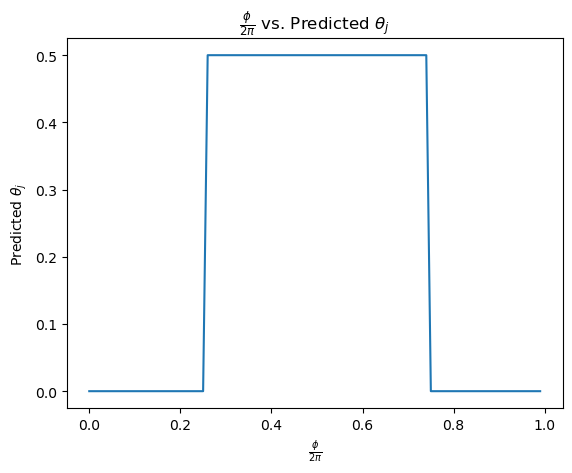

In [13]:
def PhaseE_D1_G1():
    phi_by_2pi = np.linspace(0, 0.99, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = PhaseE_D1(2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = result[0].real
            if prob > max_val:
                max_val = prob
                fin_state = result[1][0]
        theta = (0.5) * int(fin_state)
        theta_j.append(theta)

    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_D1_G1()

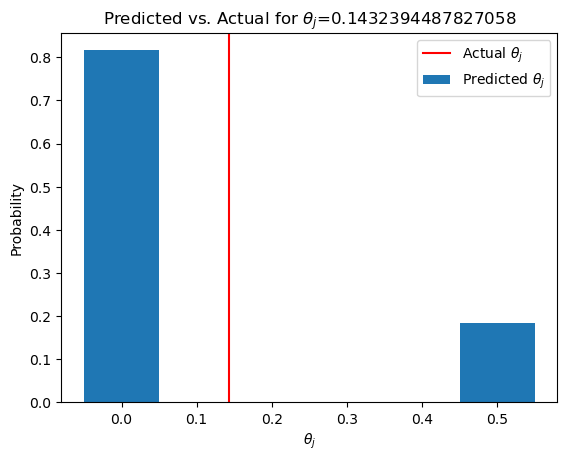

In [14]:
def PhaseE_D1_G2():
    phi_by_2pi_set = 0.1432394487827058
    computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi_set))
    computer.run(num_measures=10000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        if results[i] == '01':
            thetas.append(0)
        elif results[i] == '11':
            thetas.append(0.5)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    plt.figure()
    plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_D1_G2()

In [15]:
def animation1():
    n_frames = 100
    print(n_frames)
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=1000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        if results[i] == '01':
            thetas.append(0)
        elif results[i] == '11':
            thetas.append(0.5)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()

    def update(i):
        computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=10000)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            if results[j] == '01':
                thetas.append(0)
            elif results[j] == '11':
                thetas.append(0.5)
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
    anim.save("thetaprediction1wire.gif")
    plt.show()
# animation1()

In [16]:
def PhaseE_D2(phi):
    return f"""3
INITSTATE BASIS |001>
H 0
H 1
CPHASE 1 2 {phi}
CPHASE 0 2 {phi}
CPHASE 0 2 {phi}
H 0
CPHASE 0 1 {-m.pi/2}
H 1
SWAP 0 1
MEASURE"""

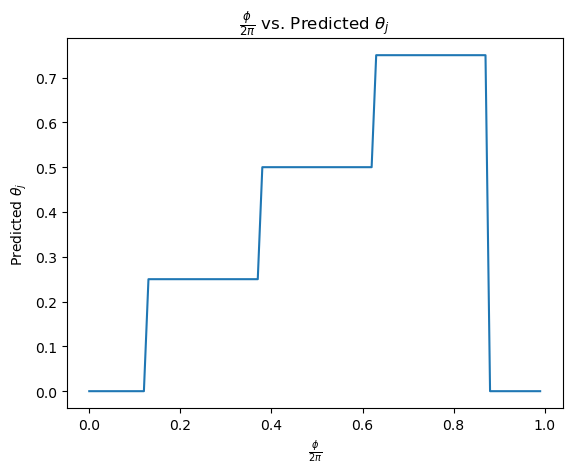

In [17]:
def PhaseE_D2_G1():
    phi_by_2pi = np.linspace(0, 0.99, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = PhaseE_D2(2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = result[0].real
            if prob > max_val:
                max_val = prob
                fin_state = result[1][:-1]
        theta = (0.5) * int(fin_state[0]) + (0.25) * int(fin_state[1])
        theta_j.append(theta)

    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_D2_G1()

In [ ]:
def PhaseE_D2_G2():
    phi_by_2pi_set = 0.1432394487827058
    computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi_set))
    computer.run(num_measures=10000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    plt.figure()
    plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_D2_G2()

In [18]:
def animation2():
    n_frames = 200
    print(n_frames)
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=1000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()

    def update(i):
        computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=10000)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            result = results[j][:-1]
            thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = 10, repeat=True, cache_frame_data=True)
    anim.save("thetaprediction2wires.gif")
    plt.show()
# animation2()

In [19]:
def QFT(n):
    st = ""
    for i in range(n):
        st += f"H {n-i-1}"
        for j in range(n-i-1):
            st += f"\nCPHASE {n-i-1} {n-i-1-j-1} {m.pi/(2**(j+1))}"
        st += "\n"
    return st[:-1]

In [20]:
QFT_description = f"""5
INITSTATE FILE myInputState.txt
{QFT(3)}"""
QFT_test_computer = Quantum_Computer(QFT_description, print_circuit=True)
PrettyPrintBinary(QFT_test_computer.run())

5
INITSTATE FILE myInputState.txt
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
{ (0.012-0.053j) |00000> + (-0.001-0.318j) |00001> + (-0.086-0.089j) |00010> + (-0.005+0.017j) |00011> + (-0.102+0.202j) |00100> + (0.022-0.008j) |00101> + (0.111-0.157j) |00110> + (0.007+0.105j) |00111> + (0.137-0.006j) |01000> + (0.094+0.142j) |01001> + (0.143+0.124j) |01010> + (-0.023-0.1j) |01011> + (-0.163-0.141j) |01100> + (-0.018+0.07j) |01101> + (-0.035+0.092j) |01110> + (0.046-0.214j) |01111> + (0.041-0.112j) |10000> + (0.044-0.125j) |10001> + (-0.101-0.294j) |10010> + (0.124-0.111j) |10011> + (0.023-0.112j) |10100> + (0.039-0.184j) |10101> + (-0.073-0.119j) |10110> + (-0.175+0.082j) |10111> + (-0.123+0.057j) |11000> + (0.168-0.087j) |11001> + (-0.214-0.063j) |11010> + (-0.051+0.096j) |11011> + (0.05-0.317j) |11100> + (0.024+0.033j) |11101> + (-0.026-0.023j) |11110> + (0.276+0.135j) |11111>}


In [21]:
def custom_description1(control, wire):
    return f"""CPHASE {control} {wire} {2*m.pi*0.3}
CNOT {control} {wire}
CPHASE {control} {wire} {2*m.pi*0.7}
CNOT {control} {wire}"""

In [22]:
def phase_estimator(n, phi=0, is_custom=False, custom_description=""):
    basis = ""
    for i in range(n):
        basis += "0"
    st = f"""{n+1}\nINITSTATE BASIS |{basis}1>\n"""
    for i in range(n):
        st+=f"H {i}\n"
    if is_custom:
        for i in range(n):
            for j in range(2**i):
                st+=f"{custom_description(n-1-i, n)}\n"
    else:
        for i in range(n):
            st+=f"CPHASE {n-1-i} {n} {2**i*phi}\n"
    st += f"{invert_description(QFT(n))}\n"
    st += f"{REVERSE(0, n)}\n"
    st += "MEASURE"
    return st

In [23]:
print(phase_estimator(6, is_custom=True, custom_description=custom_description1))

7
INITSTATE BASIS |0000001>
H 0
H 1
H 2
H 3
H 4
H 5
CPHASE 5 6 1.8849555921538759
CNOT 5 6
CPHASE 5 6 4.39822971502571
CNOT 5 6
CPHASE 4 6 1.8849555921538759
CNOT 4 6
CPHASE 4 6 4.39822971502571
CNOT 4 6
CPHASE 4 6 1.8849555921538759
CNOT 4 6
CPHASE 4 6 4.39822971502571
CNOT 4 6
CPHASE 3 6 1.8849555921538759
CNOT 3 6
CPHASE 3 6 4.39822971502571
CNOT 3 6
CPHASE 3 6 1.8849555921538759
CNOT 3 6
CPHASE 3 6 4.39822971502571
CNOT 3 6
CPHASE 3 6 1.8849555921538759
CNOT 3 6
CPHASE 3 6 4.39822971502571
CNOT 3 6
CPHASE 3 6 1.8849555921538759
CNOT 3 6
CPHASE 3 6 4.39822971502571
CNOT 3 6
CPHASE 2 6 1.8849555921538759
CNOT 2 6
CPHASE 2 6 4.39822971502571
CNOT 2 6
CPHASE 2 6 1.8849555921538759
CNOT 2 6
CPHASE 2 6 4.39822971502571
CNOT 2 6
CPHASE 2 6 1.8849555921538759
CNOT 2 6
CPHASE 2 6 4.39822971502571
CNOT 2 6
CPHASE 2 6 1.8849555921538759
CNOT 2 6
CPHASE 2 6 4.39822971502571
CNOT 2 6
CPHASE 2 6 1.8849555921538759
CNOT 2 6
CPHASE 2 6 4.39822971502571
CNOT 2 6
CPHASE 2 6 1.8849555921538759
CNOT 2

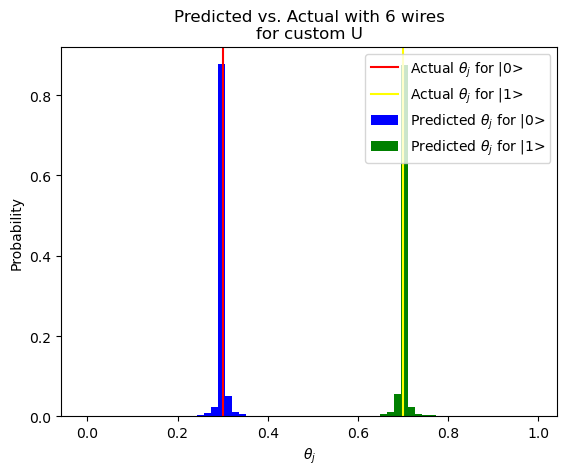

In [24]:
def custom_description_PhaseE():
    n = 6
    computer1 = Quantum_Computer(phase_estimator(6, is_custom=True, custom_description=custom_description1))
    computer1.run(num_measures=10000)
    results1 = computer1.get_last_measurement()[1]
    thetas1 = []
    for i in range(len(results1)):
        result = results1[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas1.append(theta)
    types1 = []
    [types1.append(x) for x in thetas1 if x not in types1]
    probs1 = [thetas1.count(value)/len(thetas1) for value in types1]

    vec = np.zeros(2**(n+1))
    vec[0] = 1
    computer2 = Quantum_Computer(phase_estimator(6, is_custom=True, custom_description=custom_description1))
    computer2.run(num_measures=10000, initial_state=VecToState(vec))
    results2 = computer2.get_last_measurement()[1]
    thetas2 = []
    for i in range(len(results2)):
        result = results2[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas2.append(theta)
    types2 = []
    [types2.append(x) for x in thetas2 if x not in types2]
    probs2 = [thetas2.count(value)/len(thetas2) for value in types2]

    width = 1/2**n
    if width > 0.1: width = 0.1
    plt.figure()
    plt.bar(types1, probs1, width=width, color = "blue", label = r'Predicted $\theta_j$ for |0>')
    plt.bar(types2, probs2, width=width, color="g", label = r'Predicted $\theta_j$ for |1>')
    plt.axvline(x = 0.3, color = 'r', label = r'Actual $\theta_j$ for |0>')
    plt.axvline(x = 0.7, color = 'yellow', label = r'Actual $\theta_j$ for |1>')

    plt.title(f"Predicted vs. Actual with {n} wires\n" + r"for custom U")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
custom_description_PhaseE()

In [ ]:
def PhaseE_G1_Generator(n):
    phi_by_2pi = np.linspace(0, 1, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = phase_estimator(n, 2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = result[0].real
            if prob > max_val:
                max_val = prob
                fin_state = result[1][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(fin_state[j])
        theta_j.append(theta)

    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$ with" + f" {n} wires")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_G1_Generator(6)

In [ ]:
def PhaseE_G2_Generator(n, num_measures=1000):
    phi_by_2pi_set = 0.1432394487827058
    desc = phase_estimator(n, 2*m.pi*phi_by_2pi_set)
    computer = Quantum_Computer(desc)
    computer.run(num_measures=num_measures)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas.append(theta)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    width = 1/2**n
    if width > 0.1: width = 0.1
    plt.figure()
    plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(f"Predicted vs. Actual with {n} wires\n" + r"for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_G2_Generator(6)

In [ ]:
def PhaseE_G2_Animation_Generator(n, n_frames=200, time=2, num_measures=10000):
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(phase_estimator(n, 2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=num_measures)
    results = computer.get_last_measurement()[1]
    thetas = []
    for j in range(len(results)):
        result = results[j][:-1]
        theta = 0
        for k in range(n):
            theta += (1/2)**(k+1)*int(result[k])
        thetas.append(theta)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    width = 1/2**n
    if width > 0.1: width = 0.1
    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$" + f"\nWith {n} Wires")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()
    
    def update(i):
        computer = Quantum_Computer(phase_estimator(n, 2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=num_measures)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            result = results[j][:-1]
            theta = 0
            for k in range(n):
                theta += (1/2)**(k+1)*int(result[k])
            thetas.append(theta)
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$" + f"\nWith {n} Wires")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = time*1000/n_frames, repeat=True, cache_frame_data=True)
    anim.save(f"thetaprediction{n}wires_gen.gif")
    plt.show()
# PhaseE_G2_Animation_Generator(6, n_frames=1000, time=5)

In [275]:
def Shor(n):
    if sympy.isprime(n):
        print(f"n = {n} is a prime number")
        return 1, n
    if n % 2 == 0:
        factor = int(n/2)
        print(f"{n}/2 = {factor} is our factor")
        return 2, factor
    for a in range(2, int(m.log2(n))):
        if (n**(1/a)).is_integer():
            print(f"Root a = {a} is an integer {n**(1/a)}")
            return int(n**(1/a)), int(n/(n**(1/a)))
    rng = np.random.default_rng()
    while 0<1:
        x = int(rng.integers(1, n))
        print(f"x = {x}")
        if m.gcd(x, n) != 1:
            print(f"Lucky break! x = {m.gcd(x, n)} is a factor")
            return int(m.gcd(x, n)), int(n/m.gcd(x, n))
        r = 2
        while x**r % n != 1:
            if (r>n):
                print(f"r = {r} > n = {n}")
                raise ValueError()
            r+=1
        if r % 2 != 0:
            print(f"r = {r} is odd...RIP")
            continue
        f1 = int(m.gcd(int((x**int(r/2)+1) % n), n))
        f2 = int(m.gcd(int((x**int(r/2)-1) % n), n))
        if f1 == 1 or f2 == 1 or f1 == n or f2 == n:
            continue
        return f1, f2

In [293]:
Shor(14605)

x = 10830
Lucky break! x = 5 is a factor


(5, 2921)